<a href="https://colab.research.google.com/github/ganeshIIT/lifestyle/blob/main/MyLifestyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install xmltodict -q
!pip install jupyter-dash -q

In [61]:
import pandas as pd
import xmltodict
import re
import matplotlib.pyplot as plt
import seaborn as sns

import utilities


In [62]:
def labelcleaner(df):
    df.columns = [
        utilities._cleanlabel(col) for col in df.columns
    ]
    if df.index.name:
        df.index.rename(
            utilities._cleanlabel(df.index.name),
            inplace=True
        )
    return df

In [63]:
health_datapath = '/content/drive/MyDrive/Personal/export.xml'
sleep_datapath = '/content/drive/MyDrive/Personal/AutoSleep.csv'
#workout_datapath = '/content/drive/MyDrive/Personal/Workout.csv'

In [64]:
with open(health_datapath, 'r', errors='ignore') as xml_file:
    health = xmltodict.parse(xml_file.read())

healthrecords = health['HealthData']['Record']
workoutrecords = health['HealthData']['Workout']

healthdata = pd.DataFrame(healthrecords)
workoutdata = pd.DataFrame(workoutrecords)
sleepdata = pd.read_csv(sleep_datapath)

In [65]:
health_rawsample = healthdata.sample(1000)
workout_rawsample = workoutdata.copy()
sleep_rawsample = sleepdata.copy()

In [66]:
health_rawsample.info()
workout_rawsample.info()
sleep_rawsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 100269 to 461962
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   @type                             1000 non-null   object
 1   @sourceName                       1000 non-null   object
 2   @sourceVersion                    1000 non-null   object
 3   @unit                             983 non-null    object
 4   @creationDate                     1000 non-null   object
 5   @startDate                        1000 non-null   object
 6   @endDate                          1000 non-null   object
 7   @value                            1000 non-null   object
 8   @device                           962 non-null    object
 9   MetadataEntry                     154 non-null    object
 10  HeartRateVariabilityMetadataList  3 non-null      object
dtypes: object(11)
memory usage: 93.8+ KB
<class 'pandas.core.frame.DataFrame'>


In [67]:
healthdata = labelcleaner(healthdata)
workoutdata = labelcleaner(workoutdata)
sleepdata = labelcleaner(sleepdata)

In [68]:
healthdata.columns

Index(['type', 'sourcename', 'sourceversion', 'unit', 'creationdate',
       'startdate', 'enddate', 'value', 'device', 'metadataentry',
       'heartratevariabilitymetadatalist'],
      dtype='object')

In [69]:
workoutdata.columns

Index(['workoutactivitytype', 'duration', 'durationunit', 'totaldistance',
       'totaldistanceunit', 'totalenergyburned', 'totalenergyburnedunit',
       'sourcename', 'sourceversion', 'device', 'creationdate', 'startdate',
       'enddate', 'metadataentry', 'workoutevent', 'workoutroute'],
      dtype='object')

In [70]:
sleepdata.columns

Index(['iso8601', 'fromdate', 'todate', 'bedtime', 'waketime', 'inbed',
       'awake', 'fellasleepin', 'sessions', 'asleep', 'asleepavg7',
       'efficiency', 'efficiencyavg7', 'quality', 'qualityavg7', 'deep',
       'deepavg7', 'sleepbpm', 'sleepbpmavg7', 'daybpm', 'daybpmavg7',
       'wakingbpm', 'wakingbpmavg7', 'hrv', 'hrvavg7', 'sleephrv',
       'sleephrvavg7', 'spo2avg', 'spo2min', 'spo2max', 'respavg', 'respmin',
       'respmax', 'tags', 'notes'],
      dtype='object')

In [71]:
## Apple health data cleaner
## @utilities.cleanlabel
def cleansehealthdata(df):
    return (df
     .dropna(thresh = df.shape[0]//4, axis=1)
     .rename(columns ={'type': 'datatype'})
     .assign(creationdate = lambda x: pd.to_datetime(x['creationdate']).dt.tz_convert(None),
             startdate = lambda x: pd.to_datetime(x['startdate']).dt.tz_convert(None),
             enddate = lambda x: pd.to_datetime(x['enddate']).dt.tz_convert(None),
             datatype = lambda x: x['datatype'].str.replace('HKQuantityTypeIdentifier', ''),
             device = lambda x: x['device'].fillna('No device'))
     .query("value != 'HKCategoryValueSleepAnalysisInBed'")
     .query("datatype in ['BodyMassIndex', 'Height', 'BodyMass', 'HeartRate', \
                        'RespiratoryRate', 'BodyFatPercentage', 'LeanBodyMass',\
                        'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',\
                        'ActiveEnergyBurned', 'FlightsClimbed',\
                        'AppleExerciseTime', 'RestingHeartRate', 'VO2Max',\
                        'WalkingHeartRateAverage', 'EnvironmentalAudioExposure',\
                        'HeadphoneAudioExposure', 'WalkingDoubleSupportPercentage',\
                        'SixMinuteWalkTestDistance', 'AppleStandTime', 'WalkingSpeed',\
                        'WalkingStepLength', 'WalkingAsymmetryPercentage',\
                        'HKDataTypeSleepDurationGoal', 'AppleWalkingSteadiness',\
                        'HeartRateVariabilitySDNN'] ")
     .dropna()
     .astype({'datatype':'category', 'sourcename':'category','value':'float'})
     )


## Heart watch workout data cleaner
## @utilities.cleanlabel
def cleanseworkoutdata(df):
    return (
        df
        .dropna(thresh = df.shape[0]//4, axis=1)
        .drop(['sourceversion'],
            axis = 1, errors='ignore')
        .rename(columns = {'workoutactivitytype': 'workouttype', 'metadataentry':'workoutname'})
        .assign(
            workouttype = lambda x: x['workouttype'].str.replace('HKWorkoutActivityType', ''),
            workoutname = lambda x: x['workoutname'].apply(lambda x: x.get('@value')if isinstance(x, dict) else 'unknown'),
            creationdate = lambda x: pd.to_datetime(x['creationdate']).dt.tz_convert(None),
            startdate = lambda x: pd.to_datetime(x['startdate']).dt.tz_convert(None),
            enddate = lambda x: pd.to_datetime(x['enddate']).dt.tz_convert(None),
            device = lambda x: x['device'].fillna('No device')
            )
        .astype({'workouttype':'category', 'sourcename':'category', 'workoutname': 'category'})
        .astype({'duration':'float', 'totaldistance':'float', 'totalenergyburned': 'float'})
        .dropna()
        )


## Heart watch workout data cleaner
## @utilities.cleanlabel
def cleansesleepdata(df):
    return (
      df.drop(['asleepavg7','efficiencyavg7','qualityavg7', 'deepavg7', 
            'sleepbpmavg7',  'daybpmavg7','wakingbpmavg7', 'hrvavg7',
            'sleephrvavg7', 'spo2avg', 'spo2min', 'spo2max', 'tags', 'notes'],
            axis = 1, errors='ignore')
        .dropna(thresh = df.shape[0]//4, axis=1)
        .rename(columns ={'iso8601': 'maindate'})
        .assign(maindate = lambda x: pd.to_datetime(x['maindate'])
                                        .dt.tz_convert(None).dt.normalize(),
                fromdate = lambda x: pd.to_datetime(x['fromdate']),
                todate = lambda x: pd.to_datetime(x['todate']),
                bedtime = lambda x: pd.to_datetime(x['bedtime']),
                waketime = lambda x: pd.to_datetime(x['waketime']),
                inbed= lambda x: pd.to_timedelta(x['inbed']),
                awake= lambda x: pd.to_timedelta(x['awake']),
                fellasleepin= lambda x: pd.to_timedelta(x['fellasleepin']),
                asleep= lambda x: pd.to_timedelta(x['asleep']),
                quality= lambda x: pd.to_timedelta(x['quality']),
                deep= lambda x: pd.to_timedelta(x['deep']),
                )
    )
    #return df

In [72]:
healthdata = cleansehealthdata(healthdata)
workoutdata = cleanseworkoutdata(workoutdata)
sleepdata = cleansesleepdata(sleepdata)

In [73]:
sleepdata.head()

,maindate,fromdate,todate,bedtime,waketime,inbed,awake,fellasleepin,sessions,asleep,...,quality,deep,sleepbpm,daybpm,wakingbpm,hrv,sleephrv,respavg,respmin,respmax
0,2021-10-09,2021-10-08,2021-10-09,2021-10-08 22:51:00,2021-10-09 05:36:00,0 days 06:45:00,0 days 00:21:00,0 days,1,0 days 06:24:00,...,0 days 04:57:00,NaT,71.7,83.4,71.0,70,55.0,16.1,13.0,20.5
1,2021-10-10,2021-10-09,2021-10-10,2021-10-09 22:45:00,2021-10-10 03:46:00,0 days 05:01:00,0 days 01:03:00,0 days,1,0 days 03:58:00,...,0 days 02:52:28,0 days 00:14:00,74.1,79.9,76.0,49,43.0,16.6,14.5,19.0
2,2021-10-11,2021-10-10,2021-10-11,2021-10-10 20:56:00,2021-10-11 06:35:00,0 days 09:39:00,0 days 01:36:00,0 days,1,0 days 08:03:00,...,0 days 05:54:53,0 days 00:29:16,69.7,87.7,67.0,88,61.0,16.1,11.5,18.5
3,2021-10-12,2021-10-11,2021-10-12,2021-10-11 22:00:00,2021-10-12 05:21:00,0 days 07:21:00,0 days 00:00:00,0 days,1,0 days 07:21:00,...,0 days 05:17:57,0 days 01:16:02,69.5,83.1,61.0,104,64.0,16.3,13.0,19.0
4,2021-10-13,2021-10-12,2021-10-13,2021-10-12 22:45:00,2021-10-13 04:41:00,0 days 05:56:00,0 days 00:00:00,0 days,1,0 days 05:56:00,...,0 days 04:38:22,0 days 01:14:10,68.3,81.0,65.0,42,38.0,15.7,12.5,20.0


In [74]:
healthdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973928 entries, 0 to 986936
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   datatype       973928 non-null  category      
 1   sourcename     973928 non-null  category      
 2   sourceversion  973928 non-null  object        
 3   unit           973928 non-null  object        
 4   creationdate   973928 non-null  datetime64[ns]
 5   startdate      973928 non-null  datetime64[ns]
 6   enddate        973928 non-null  datetime64[ns]
 7   value          973928 non-null  float64       
 8   device         973928 non-null  object        
dtypes: category(2), datetime64[ns](3), float64(1), object(3)
memory usage: 61.3+ MB


In [75]:
workoutdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   workouttype            362 non-null    category      
 1   duration               362 non-null    float64       
 2   durationunit           362 non-null    object        
 3   totaldistance          362 non-null    float64       
 4   totaldistanceunit      362 non-null    object        
 5   totalenergyburned      362 non-null    float64       
 6   totalenergyburnedunit  362 non-null    object        
 7   sourcename             362 non-null    category      
 8   device                 362 non-null    object        
 9   creationdate           362 non-null    datetime64[ns]
 10  startdate              362 non-null    datetime64[ns]
 11  enddate                362 non-null    datetime64[ns]
 12  workoutname            362 non-null    category      
dtypes: ca

In [76]:
sleepdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   maindate      333 non-null    datetime64[ns] 
 1   fromdate      333 non-null    datetime64[ns] 
 2   todate        333 non-null    datetime64[ns] 
 3   bedtime       333 non-null    datetime64[ns] 
 4   waketime      333 non-null    datetime64[ns] 
 5   inbed         333 non-null    timedelta64[ns]
 6   awake         333 non-null    timedelta64[ns]
 7   fellasleepin  331 non-null    timedelta64[ns]
 8   sessions      333 non-null    int64          
 9   asleep        333 non-null    timedelta64[ns]
 10  efficiency    333 non-null    float64        
 11  quality       331 non-null    timedelta64[ns]
 12  deep          282 non-null    timedelta64[ns]
 13  sleepbpm      331 non-null    float64        
 14  daybpm        329 non-null    float64        
 15  wakingbpm     333 non-n

In [77]:
health_excel = healthdata.sample(10000)
workout_excel = workoutdata.copy()
sleep_excel = sleepdata.copy()

with pd.ExcelWriter("lifestyle.xlsx") as writer:
    health_excel.to_excel(writer, sheet_name="health", index=False)
    workout_excel.to_excel(writer, sheet_name="workout", index=False)
    sleep_excel.to_excel(writer, sheet_name="sleep", index=False)

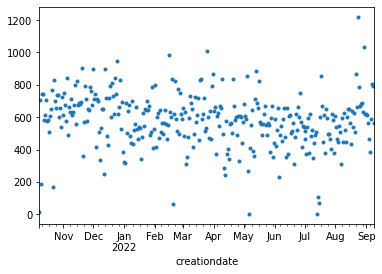

In [78]:
(
healthdata.loc[healthdata['datatype']=='ActiveEnergyBurned']
 .groupby(pd.Grouper(key = 'creationdate',freq= '1D'))['value']
 .sum()
#  .rolling(5)
#  .mean()
 .plot(style = '.')
)

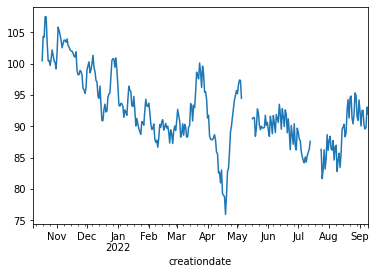

In [79]:
(
healthdata.loc[healthdata['datatype']=='HeartRate']
 .groupby(pd.Grouper(key = 'creationdate',freq= '1D'))['value']
 .mean()
 .rolling(10)
 .mean()
 .plot()
)

In [80]:
healthdata.loc[healthdata['datatype']=='BodyFatPercentage']['value'].mean()

0.1542784810126582

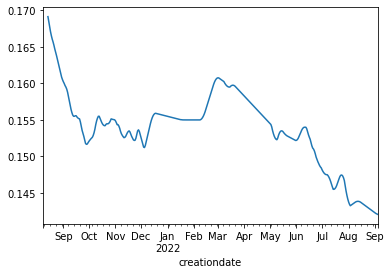

In [81]:
(
healthdata.loc[healthdata['datatype']=='BodyFatPercentage']
 .groupby(pd.Grouper(key = 'creationdate',freq= '1D'))['value']
 .mean().interpolate()
 .rolling(7).mean()
 .plot()
)

In [82]:
health_rawsample['@type'].unique()

array(['HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierEnvironmentalAudioExposure',
       'HKQuantityTypeIdentifierHeadphoneAudioExposure',
       'HKQuantityTypeIdentifierRespiratoryRate',
       'HKQuantityTypeIdentifierAppleStandTime',
       'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKCategoryTypeIdentifierSleepAnalysis',
       'HKCategoryTypeIdentifierAppleStandHour',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierWalkingStepLength',
       'HKQuantityTypeIdentifierWalkingSpeed',
       'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
       'HKQuantityTypeIdentifierWalkingAsymmetryPercentage'], dtype=object)

In [83]:
health_rawsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 100269 to 461962
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   @type                             1000 non-null   object
 1   @sourceName                       1000 non-null   object
 2   @sourceVersion                    1000 non-null   object
 3   @unit                             983 non-null    object
 4   @creationDate                     1000 non-null   object
 5   @startDate                        1000 non-null   object
 6   @endDate                          1000 non-null   object
 7   @value                            1000 non-null   object
 8   @device                           962 non-null    object
 9   MetadataEntry                     154 non-null    object
 10  HeartRateVariabilityMetadataList  3 non-null      object
dtypes: object(11)
memory usage: 93.8+ KB


In [84]:
healthdata[healthdata.datatype.isin(['BodyMassIndex', 'HeartRate',
       'RespiratoryRate', 'BodyFatPercentage', 'LeanBodyMass',
       'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',
       'ActiveEnergyBurned', 
       'RestingHeartRate', 'VO2Max', 'WalkingHeartRateAverage',
       'AppleStandTime', 'WalkingSpeed', 'WalkingStepLength',
       'WalkingAsymmetryPercentage', 'HKDataTypeSleepDurationGoal','HeartRateVariabilitySDNN'])]

,datatype,sourcename,sourceversion,unit,creationdate,startdate,enddate,value,device
0,BodyMassIndex,Fitdays,1,count,2021-08-08 23:38:31,2021-08-08 23:38:28,2021-08-08 23:38:28,27.0000,No device
1,BodyMassIndex,Fitdays,1,count,2021-08-11 00:17:06,2021-08-11 00:17:03,2021-08-11 00:17:03,26.7000,No device
2,BodyMassIndex,Fitdays,1,count,2021-08-13 01:09:28,2021-08-13 01:09:25,2021-08-13 01:09:25,26.6000,No device
3,BodyMassIndex,Fitdays,1,count,2021-08-15 01:10:15,2021-08-15 01:10:12,2021-08-15 01:10:12,26.5000,No device
4,BodyMassIndex,Fitdays,1,count,2021-08-16 01:35:22,2021-08-16 01:35:19,2021-08-16 01:35:19,26.4000,No device
...,...,...,...,...,...,...,...,...,...
986932,HeartRateVariabilitySDNN,Ganesh’s Apple Watch,8.7,ms,2022-09-09 12:06:17,2022-09-09 12:05:14,2022-09-09 12:06:13,25.0527,"<<HKDevice: 0x281d656d0>, name:Apple Watch, ma..."
986933,HeartRateVariabilitySDNN,Ganesh’s Apple Watch,8.7,ms,2022-09-09 14:23:13,2022-09-09 14:22:10,2022-09-09 14:23:09,95.2263,"<<HKDevice: 0x281d656d0>, name:Apple Watch, ma..."
986934,HeartRateVariabilitySDNN,Ganesh’s Apple Watch,8.7,ms,2022-09-09 16:01:44,2022-09-09 16:00:42,2022-09-09 16:01:41,38.9691,"<<HKDevice: 0x281d656d0>, name:Apple Watch, ma..."
986935,HeartRateVariabilitySDNN,Ganesh’s Apple Watch,8.7,ms,2022-09-09 18:01:46,2022-09-09 18:00:43,2022-09-09 18:01:42,65.5212,"<<HKDevice: 0x281d656d0>, name:Apple Watch, ma..."


In [85]:
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

app = JupyterDash(__name__)

app.layout = html.Div(
    [
        html.H4("Interactive color selection with simple Dash example"),
        html.P("Select color:"),
        dcc.Dropdown(
            id="dropdown",
            options=["Gold", "MediumTurquoise", "LightGreen"],
            value="Gold",
            clearable=False,
        ),
        dcc.Graph(id="graph"),
    ]
)


@app.callback(
    Output("graph", "figure"),
    Input("dropdown", "value"),
)
def display_color(color):
    fig = go.Figure(go.Bar(x=["a", "b", "c"], y=[2, 3, 1], marker_color=color))
    return fig


if __name__ == "__main__":
    app.run_server(debug=True, mode = 'inline', port =8030)

<IPython.core.display.Javascript object>

In [86]:
dayname = sleepdata.set_index('maindate').index.day_name()
dayname

Index(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Monday',
       ...
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday'],
      dtype='object', name='maindate', length=333)

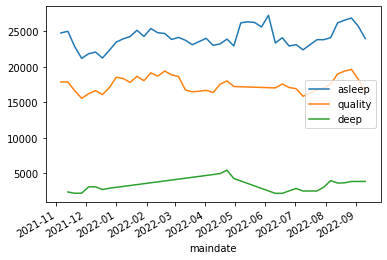

In [87]:
(
    sleepdata.set_index('maindate').loc[dayname=='Saturday']
    #.groupby()
    [['asleep', 'quality', 'deep']]
     #.fillna('mean')
    #.mean()
    .apply(lambda x: x.dt.seconds)
    .rolling(5).mean()
    .interpolate()
    .plot()
)


In [88]:
sleepdata['maindate'].dt.month_name().unique()
(
    (sleepdata
        .groupby([sleepdata['maindate'].dt.month_name(),sleepdata['maindate'].dt.day_name()])['asleep']
        .mean().dt.seconds/3600)
        .unstack().reset_index()
        
)

maindate,maindate,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,April,6.700000,7.766667,6.376667,6.033333,7.220833,7.504167,5.966667
1,August,7.445833,7.450000,7.562500,6.470833,8.541667,7.550000,7.266667
2,December,6.613333,6.958333,6.350000,5.916667,6.093333,4.979167,7.183333
3,February,6.237500,5.454167,6.587500,8.020833,6.037500,7.862500,6.100000
4,January,7.658333,6.613333,6.746667,6.600000,6.183333,7.270833,7.187500
5,July,7.620833,8.833333,6.595833,6.586667,6.938889,7.033333,7.958333
6,June,6.750000,6.466667,6.545833,6.958333,7.253333,6.691667,7.123333
7,March,6.654167,7.200000,6.779167,6.445833,6.396667,6.946667,6.570000
8,May,6.777778,6.816667,7.704167,7.096667,7.283333,7.163333,6.754167
9,November,6.650000,6.260000,5.929167,6.458333,5.766667,7.216667,6.441667


In [89]:
sleepdata['maindate'].dt.day_name().unique()

weekdaysleep = sleepdata.groupby(sleepdata['maindate'].dt.day_name())['asleep'].mean().dt.seconds/3600
weekdaysleep

maindate
Friday       6.800000
Monday       6.978056
Saturday     6.699444
Sunday       6.600833
Thursday     6.795556
Tuesday      7.028611
Wednesday    6.914167
Name: asleep, dtype: float64

In [90]:
go.Figure(go.Bar(x=weekdaysleep.index, y=weekdaysleep, marker_color = 'blue'))

In [91]:
app = JupyterDash(__name__)

weekdays = sleepdata['maindate'].dt.day_name().unique()

app.layout = html.Div(
    [
        html.H4("Interactive color selection with simple Dash example"),
        html.P("Select color:"),
        dcc.Dropdown(
            id="dropdown",
            options=weekdays,
            value=weekdays[0],
            clearable=False,
        ),
        dcc.Graph(id="graph"),
    ]
)


@app.callback(
    Output("graph", "figure"),
    Input("dropdown", "value"),
)
def display_color(color):
    fig = go.Figure(go.Bar(x=["a", "b", "c"], y=[2, 3, 1], marker_color=color))
    return fig


if __name__ == "__main__":
    app.run_server(debug=True, mode = 'inline', port =8030)

<IPython.core.display.Javascript object>

In [92]:
(
    sleepdata
        .rename(columns={'maindate':'creationdate'})
        .set_index('creationdate')
)

,fromdate,todate,bedtime,waketime,inbed,awake,fellasleepin,sessions,asleep,efficiency,quality,deep,sleepbpm,daybpm,wakingbpm,hrv,sleephrv,respavg,respmin,respmax
creationdate,,,,,,,,,,,,,,,,,,,,
2021-10-09,2021-10-08,2021-10-09,2021-10-08 22:51:00,2021-10-09 05:36:00,0 days 06:45:00,0 days 00:21:00,0 days,1,0 days 06:24:00,94.8,0 days 04:57:00,NaT,71.7,83.4,71.0,70,55.0,16.1,13.0,20.5
2021-10-10,2021-10-09,2021-10-10,2021-10-09 22:45:00,2021-10-10 03:46:00,0 days 05:01:00,0 days 01:03:00,0 days,1,0 days 03:58:00,79.1,0 days 02:52:28,0 days 00:14:00,74.1,79.9,76.0,49,43.0,16.6,14.5,19.0
2021-10-11,2021-10-10,2021-10-11,2021-10-10 20:56:00,2021-10-11 06:35:00,0 days 09:39:00,0 days 01:36:00,0 days,1,0 days 08:03:00,83.4,0 days 05:54:53,0 days 00:29:16,69.7,87.7,67.0,88,61.0,16.1,11.5,18.5
2021-10-12,2021-10-11,2021-10-12,2021-10-11 22:00:00,2021-10-12 05:21:00,0 days 07:21:00,0 days 00:00:00,0 days,1,0 days 07:21:00,100.0,0 days 05:17:57,0 days 01:16:02,69.5,83.1,61.0,104,64.0,16.3,13.0,19.0
2021-10-13,2021-10-12,2021-10-13,2021-10-12 22:45:00,2021-10-13 04:41:00,0 days 05:56:00,0 days 00:00:00,0 days,1,0 days 05:56:00,100.0,0 days 04:38:22,0 days 01:14:10,68.3,81.0,65.0,42,38.0,15.7,12.5,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,2022-09-05,2022-09-06,2022-09-05 21:47:00,2022-09-06 04:44:00,0 days 06:57:00,0 days 00:00:00,0 days,1,0 days 06:57:00,100.0,0 days 05:05:09,0 days 01:29:21,62.8,74.6,62.0,57,49.0,17.0,14.5,22.5
2022-09-07,2022-09-06,2022-09-07,2022-09-06 20:45:00,2022-09-07 06:23:00,0 days 09:38:00,0 days 00:33:00,0 days,1,0 days 09:05:00,94.3,0 days 06:36:44,0 days 01:02:17,63.6,76.2,63.0,58,53.0,16.6,13.5,21.5
2022-09-08,2022-09-07,2022-09-08,2022-09-07 20:30:00,2022-09-08 06:16:00,0 days 10:42:00,0 days 01:31:00,0 days,2,0 days 09:11:00,84.5,0 days 05:39:23,NaT,69.3,79.4,68.0,70,54.0,17.9,15.0,22.0


In [93]:
healthdata.datatype.nunique()

27

In [94]:
# .query("datatype in ['BodyMassIndex', 'Height', 'BodyMass', 'HeartRate', \
#                         'RespiratoryRate', 'BodyFatPercentage', 'LeanBodyMass',\
#                         'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',\
#                         'ActiveEnergyBurned', 'FlightsClimbed',\
#                         'AppleExerciseTime', 'RestingHeartRate', 'VO2Max',\
#                         'WalkingHeartRateAverage', 'EnvironmentalAudioExposure',\
#                         'HeadphoneAudioExposure', 'WalkingDoubleSupportPercentage',\
#                         'SixMinuteWalkTestDistance', 'AppleStandTime', 'WalkingSpeed',\
#                         'WalkingStepLength', 'WalkingAsymmetryPercentage',\
#                         'HKDataTypeSleepDurationGoal', 'AppleWalkingSteadiness',\
#                         'HeartRateVariabilitySDNN'] ")

In [95]:
(healthdata
 .assign(creationdate = lambda x: x.creationdate.dt.normalize())
 .query("datatype in ['BodyMassIndex'] ")
 .groupby(['creationdate', 'datatype'])['value'].mean().dropna()

 )

creationdate  datatype     
2021-08-08    BodyMassIndex    27.0
2021-08-11    BodyMassIndex    26.7
2021-08-13    BodyMassIndex    26.6
2021-08-15    BodyMassIndex    26.5
2021-08-16    BodyMassIndex    26.4
                               ... 
2022-07-27    BodyMassIndex    24.5
2022-07-28    BodyMassIndex    24.4
2022-08-09    BodyMassIndex    24.4
2022-09-01    BodyMassIndex    24.3
2022-09-04    BodyMassIndex    24.2
Name: value, Length: 74, dtype: float64

In [96]:
(healthdata
        .assign(creationdate = lambda x: x.creationdate.dt.normalize())
        .query("datatype in ['HeartRate','HeartRateVariabilitySDNN'] ")
        .groupby(['creationdate', 'datatype'],observed =True)['value'].agg(['min', 'max']).unstack()
        .pipe(utilities.flatten_cols)
    )

,min_HeartRate,min_HeartRateVariabilitySDNN,max_HeartRate,max_HeartRateVariabilitySDNN
creationdate,,,,
2021-10-08,63.0,34.3289,84.0,70.3527
2021-10-09,52.0,25.0087,170.0,58.5288
2021-10-10,59.0,25.5820,105.0,70.7496
2021-10-11,49.0,23.2218,166.0,103.8290
2021-10-12,57.0,24.6120,172.0,83.6158
...,...,...,...,...
2022-09-05,56.0,20.6158,121.0,74.0787
2022-09-06,46.0,19.3722,163.0,89.1370
2022-09-07,46.0,22.5268,175.0,74.8563


In [97]:
mergeddata = (
    (healthdata
        .assign(creationdate = lambda x: x.creationdate.dt.normalize())
        .query("datatype in ['BodyMassIndex', 'Height', 'BodyMass', 'HeartRate', \
                                'RespiratoryRate', 'BodyFatPercentage', 'LeanBodyMass',\
                                'RestingHeartRate', 'VO2Max',\
                                'WalkingHeartRateAverage', 'EnvironmentalAudioExposure',\
                                'HeadphoneAudioExposure', 'WalkingDoubleSupportPercentage',\
                                'SixMinuteWalkTestDistance','WalkingSpeed',\
                                'WalkingStepLength', 'WalkingAsymmetryPercentage',\
                                'HKDataTypeSleepDurationGoal', 'AppleWalkingSteadiness',\
                                'HeartRateVariabilitySDNN'] ")
        .groupby(['creationdate', 'datatype'],observed =True)['value'].mean().unstack()
    )
    ## merging the two DFs side by side
    .merge(
            (healthdata
                .assign(creationdate = lambda x: x.creationdate.dt.normalize())
                .query("datatype in ['StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',\
                                        'ActiveEnergyBurned', 'FlightsClimbed',\
                                        'AppleExerciseTime',\
                                        'AppleStandTime']")
                .groupby(['creationdate', 'datatype'], observed =True)['value'].sum().unstack()
            ),
           how='outer', left_index=True, right_index=True
    )
    .merge(
        (sleepdata
            .rename(columns={'maindate':'creationdate'})
            .set_index('creationdate')
        ),
        how='left', left_index=True, right_index=True
    )
    .merge(
        (workoutdata.set_index('creationdate')
            .groupby(pd.Grouper(freq='1D'))[['duration', 'totaldistance','totalenergyburned']]
            .sum()
        ),how='left', left_index=True, right_index=True
    )
    .merge(
        (healthdata
        .assign(creationdate = lambda x: x.creationdate.dt.normalize())
        .query("datatype in ['HeartRate','HeartRateVariabilitySDNN'] ")
        .groupby(['creationdate', 'datatype'],observed =True)['value'].agg(['min', 'max']).unstack()
        .pipe(utilities.flatten_cols)
        ),how='left', left_index=True, right_index=True
    )
)








In [98]:
healthdata.query("datatype == 'BasalEnergyBurned'")['value'].sum()

654467.8570000002

In [99]:
sleepdata['asleep'].sum()

Timedelta('94 days 18:51:00')

In [100]:
workoutdata['totalenergyburned'].sum()

78849.29036980342

In [101]:
workoutdata.columns

Index(['workouttype', 'duration', 'durationunit', 'totaldistance',
       'totaldistanceunit', 'totalenergyburned', 'totalenergyburnedunit',
       'sourcename', 'device', 'creationdate', 'startdate', 'enddate',
       'workoutname'],
      dtype='object')

In [102]:
mergeddata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 2020-01-03 to 2022-09-09
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   BodyMassIndex                   74 non-null     float64        
 1   Height                          1 non-null      float64        
 2   BodyMass                        82 non-null     float64        
 3   HeartRate                       335 non-null    float64        
 4   RespiratoryRate                 334 non-null    float64        
 5   BodyFatPercentage               74 non-null     float64        
 6   LeanBodyMass                    74 non-null     float64        
 7   RestingHeartRate                323 non-null    float64        
 8   VO2Max                          36 non-null     float64        
 9   WalkingHeartRateAverage         318 non-null    float64        
 10  EnvironmentalAudioExposure      334 non-nul

In [103]:
import plotly.express as px

In [104]:
fig = px.scatter(mergeddata['2022'], x=mergeddata['2022'].index, y='asleep')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [105]:
mergeddata.shape01

AttributeError: ignored

In [ ]:
mergeddata['2020-'].index